In [52]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [54]:
df = pd.read_csv(f'../data/PIKK/2020-10-01 - 2021-10-02.csv', index_col=0, parse_dates=['time'], dayfirst=True)
df.head()

,figi,interval,o,c,h,l,v,time
0,BBG004S68BH6,15min,569.7,569.7,570.2,567.5,294,2020-10-01 07:00:00+00:00
1,BBG004S68BH6,15min,570.0,569.7,570.3,569.4,185,2020-10-01 07:15:00+00:00
2,BBG004S68BH6,15min,570.0,570.2,570.3,569.5,138,2020-10-01 07:30:00+00:00
3,BBG004S68BH6,15min,570.0,570.6,570.6,570.0,255,2020-10-01 07:45:00+00:00
4,BBG004S68BH6,15min,570.8,570.9,571.0,570.4,235,2020-10-01 08:00:00+00:00


In [55]:
test_size = 74
train_df = df[:-test_size]
test_df = df[-test_size:]

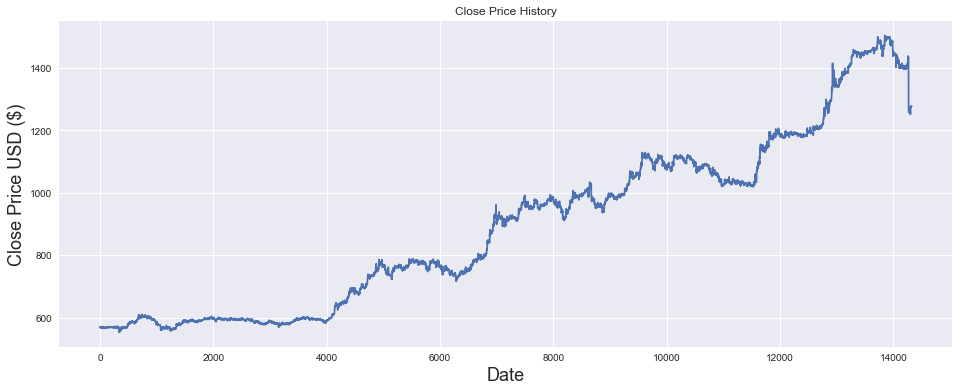

In [56]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['c'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [57]:
df.tail()['c']

14321    1276.8
14322    1276.7
14323    1277.0
14324    1277.8
14325    1278.0
Name: c, dtype: float64

In [58]:
data = df.filter(['c'])
dataset = data.values

training_data_len = int(np.ceil(len(dataset) * .95))
training_data_len
type(dataset)

numpy.ndarray

In [59]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01631236],
       [0.01631236],
       [0.01683856],
       ...,
       [0.76068196],
       [0.76152389],
       [0.76173437]])

In [60]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(test_size, len(train_data)):
    x_train.append(train_data[i-test_size: i, 0])
    y_train.append(train_data[i, 0])
    if i <= test_size + 1:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.01631236, 0.01631236, 0.01683856, 0.01725952, 0.01757525,
       0.01768049, 0.01747001, 0.01662808, 0.01747001, 0.01757525,
       0.01725952, 0.01747001, 0.01757525, 0.01378657, 0.01547043,
       0.01525995, 0.01557567, 0.0151547 , 0.01557567, 0.01557567,
       0.01547043, 0.01557567, 0.01525995, 0.01557567, 0.01483898,
       0.01536519, 0.01378657, 0.01483898, 0.01483898, 0.0151547 ,
       0.01494422, 0.01557567, 0.01483898, 0.01504946, 0.01326037,
       0.01547043, 0.01610187, 0.01473374, 0.01420754, 0.01420754,
       0.01347085, 0.01389181, 0.01389181, 0.01368133, 0.01399705,
       0.0146285 , 0.01536519, 0.01525995, 0.01504946, 0.01536519,
       0.01557567, 0.01557567, 0.01662808, 0.01568091, 0.0169438 ,
       0.01336561, 0.01483898, 0.01452326, 0.01578615, 0.01568091,
       0.01368133, 0.01262892, 0.01210272, 0.01389181, 0.01420754,
       0.01410229, 0.01420754, 0.01483898, 0.01483898, 0.01494422,
       0.01589139, 0.01578615, 0.01557567, 0.01557567])]
[0.0

In [67]:
(x_train.shape[1], 1)

(74, 1)

In [61]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [62]:
%%time

model.fit(x_train, y_train, batch_size=1, epochs=1)

13536/13536 [==============================] - 203s 15ms/step - loss: 2.5122e-04

In [63]:
test_data = scaled_data[training_data_len - test_size: , :]

x_test = []
y_test = dataset[training_data_len: , :]

for i in range(test_size, len(test_data)):
    x_test.append(test_data[i-test_size: i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

9.40112360759162

In [68]:
len(test_data)

790

In [64]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predicted'] = predictions
valid

C:\Users\spark\AppData\Local\Temp/ipykernel_17620/2121949022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predicted'] = predictions


,c,Predicted
13610,1455.9,1450.377686
13611,1456.0,1450.406982
13612,1456.2,1450.411621
13613,1456.1,1450.514893
13614,1455.4,1450.574951
...,...,...
14321,1276.8,1272.144287
14322,1276.7,1272.265869
14323,1277.0,1272.251709
14324,1277.8,1272.357910


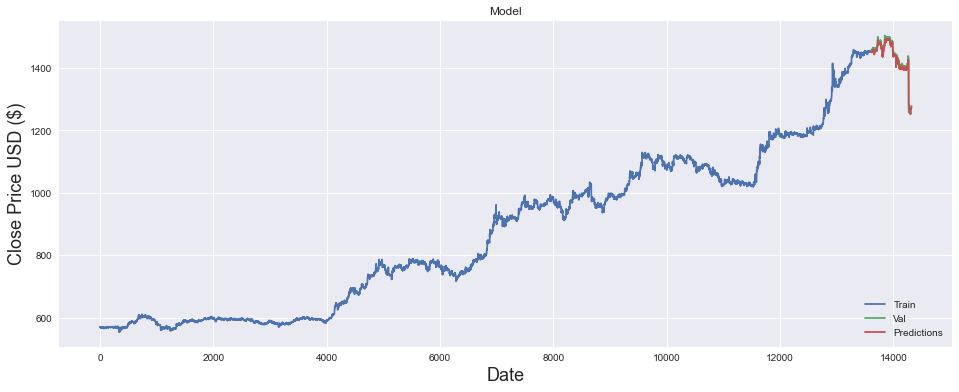

In [65]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['c'])
plt.plot(valid[['c', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

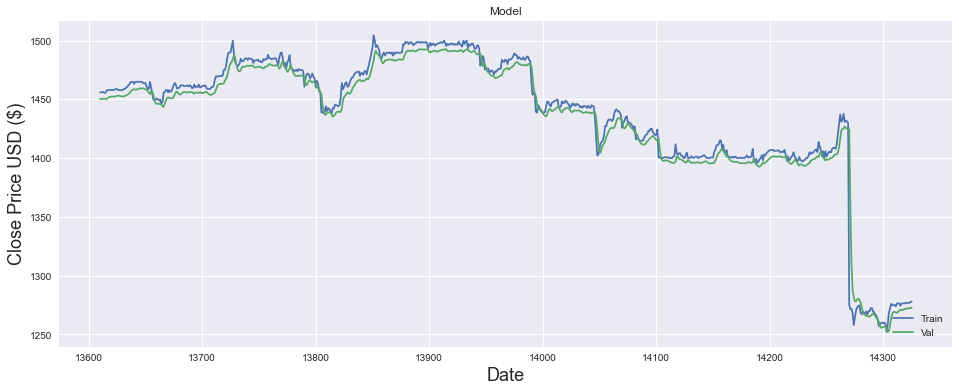

In [66]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['c', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()